In [1]:
"""
Train convolutional network for sentiment analysis on IMDB corpus. Based on
"Convolutional Neural Networks for Sentence Classification" by Yoon Kim
http://arxiv.org/pdf/1408.5882v2.pdf

For "CNN-rand" and "CNN-non-static" gets to 88-90%, and "CNN-static" - 85% after 2-5 epochs with following settings:
embedding_dim = 50          
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

Differences from original article:
- larger IMDB corpus, longer sentences; sentence length is very important, just like data size
- smaller embedding dimension, 50 instead of 300
- 2 filter sizes instead of original 3
- fewer filters; original work uses 100, experiments show that 3-10 is enough;
- random initialization is no worse than word2vec init on IMDB corpus
- sliding Max Pooling instead of original Global Pooling

https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras

"""

import numpy as np
import data_helpers
from w2v import train_word2vec

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import itertools
from keras.callbacks import Callback

%matplotlib inline
sns.set(style='whitegrid', palette='muted')


from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
np.random.seed(0)

Using TensorFlow backend.


In [2]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(model, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    y_pred = model.predict(x_test)

    class_labels = np.argmax(y_test, axis=1) 
    
    print(metrics.classification_report(class_labels, y_pred.argmax(axis=1), 
                                        target_names=labels, digits=3))
    
    #Plot ROC curve
    plot_ROC(class_labels, y_pred)
    
    cm = confusion_matrix(class_labels, 
                          y_pred.argmax(axis=1))
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_ROC(class_labels, y_pred):
        
    print("Accuracy = {0} \t AUC = {1}".format(accuracy_score(class_labels, y_pred.argmax(axis=1)),
                                           roc_auc_score(class_labels, y_pred[:, 1])))

    fpr, tpr, _ = roc_curve(class_labels, y_pred[:, 1])
    roc_auc = auc(fpr, tpr)
#     print(fpr, tpr)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, score))



In [3]:
# ---------------------- Parameters section -------------------
#
# Model type. See Kim Yoon's Convolutional Neural Networks for Sentence Classification, Section 3
# model_type = "CNN-non-static"  # CNN-rand|CNN-non-static|CNN-static
# model_type = 'CNN-rand'
model_type = "CNN-static"  

# Model Hyperparameters
embedding_dim = 300
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.2, 0.5)
hidden_dims = 100

# Training parameters
batch_size = 128
num_epochs = 50

# Prepossessing parameters
sequence_length = 100
max_words = 10000

# Word2Vec parameters (see train_word2vec)
min_word_count = 1
context = 10

#
# ---------------------- Parameters end -----------------------

In [4]:
def get_splits(X, y, max_words = 20000, MAX_SEQUENCE_LENGTH = 100, EMBEDDING_DIM = 300):
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    tokenizer.fit_on_texts(X)

    X = tokenizer.texts_to_sequences(X)
    Y = pd.get_dummies(y).values
    # print(X[0])

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH,  padding="post", truncating="post")
    # print(X[10])

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, 
                                                        random_state = 42)

    # print(y_train[100])

    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)
    print('y_train shape:', y_train.shape)
    print('y_test shape:', y_test.shape)
    
    return x_train, x_test, y_train, y_test, word_index

In [7]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('/home/paperspace/sonic/fakeNews/')

from data_util import get_fake_or_real_news, get_politifact, get_fact_fake

# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fake_or_real_news()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_politifact()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fact_fake()

# ##### SNOPES ##############################################
def to_label(cat):
    return categories[cat]

# data_train = pd.read_csv('../data/snopes_processed.tsv', sep='\t')
# # data_train['label'] = data_train['label'].apply(str)
# # data_train['label'] = data_train['label'].astype(str)
# categories = {True:u'true', False: u'false'}
# data_train['label'] = data_train['label'].apply(to_label)
# X = data_train['claim'].values.astype(str)
# y = data_train['label'].values
# labels = data_train['label'].unique()
# print(labels)
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
# ############################################################

##### FakeNewsNet #####################################
# def add_text(row):
#     return row['title_tokens'] + ' ' + row['text_tokens'] 
    
    
# categories = {'FakeNewsContent':'False', 'RealNewsContent':'True'}
# data_train = pd.read_csv('../data/fakeNewsNet.csv', sep='\t')
# data_train.dropna(how='any', inplace=True) 
# print(data_train['collected_by'].unique())
# print(data_train['label'].unique())
# print(data_train.isnull().values.any())
# data_train['label'] = data_train['label'].apply(to_label)
# data_train['document'] = data_train.apply(add_text, axis=1)
# X =  data_train['document'].values
# y = data_train['label'].values
# labels = data_train['label'].unique()
# print(data_train['label'].value_counts())
# labels = data_train['label'].unique()
# print(labels)
# x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
#################################################

##### Unreliable News Data ##################################
data_train = pd.read_csv('../data/newsfiles/fulltrain.csv', names=['label', 'text'])
categories = {1:"Satire",2:"Hoax",
              3:"Propaganda",4:"Trusted"}

data_train['label'] = data_train['label'].apply(to_label)
X =  data_train['text'].values
y = data_train['label'].values
labels = data_train['label'].unique()
print(data_train['label'].value_counts())
x_train, x_test, y_train, y_test, word_index = get_splits(X, y)
############################


vocabulary_inv = dict((v, k) for k, v in word_index.items())
print('Found %s unique tokens.' % len(vocabulary_inv))
vocabulary_inv[0] = "<PAD/>"
 
# Data Preparation
print("Load data...")
# x_train, y_train, x_test, y_test, vocabulary_inv = load_data(data_source)
# x_train, y_train, x_test, y_test, vocabulary_inv = load_data_hansard(data_train)

if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

# x_train[:10]

Propaganda    17870
Satire        14047
Trusted        9995
Hoax           6942
Name: label, dtype: int64
Found 468462 unique tokens.
x_train shape: (39083, 100)
x_test shape: (9771, 100)
y_train shape: (39083, 4)
y_test shape: (9771, 4)
Found 468462 unique tokens.
Load data...
x_train shape: (39083, 100)
x_test shape: (9771, 100)
Vocabulary Size: 468463


In [8]:
max_words = max_words
MAX_SEQUENCE_LENGTH = sequence_length
EMBEDDING_DIM = embedding_dim

In [9]:
# Prepare embedding layer weights and convert inputs for static model
print("Model type is", model_type)
if model_type in ["CNN-non-static", "CNN-static"]:
    embedding_weights = train_word2vec(np.vstack((x_train, x_test)), vocabulary_inv, 
                                       sentences=X,
                                       model_name='/home/paperspace/.keras/datasets/GoogleNews-vectors-negative300.bin',
#                                        model_name='',                                       
                                       num_features=embedding_dim,
                                       min_word_count=min_word_count, context=context)
    
    if model_type == "CNN-static":
        x_train = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_train])
        x_test = np.stack([np.stack([embedding_weights[word] for word in sentence]) for sentence in x_test])
        print("x_train static shape:", x_train.shape)
        print("x_test static shape:", x_test.shape)

elif model_type == "CNN-rand":
    embedding_weights = None
else:
    raise ValueError("Unknown model type")

Model type is CNN-static
Load existing Word2Vec model 'GoogleNews-vectors-negative300.bin'
x_train static shape: (39083, 100, 300)
x_test static shape: (9771, 100, 300)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 300)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 100, 300)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 10)       9010        dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 93, 10)       24010       dropout_1[0][0]                  
__________________________________________________________________________________________________
max_poolin

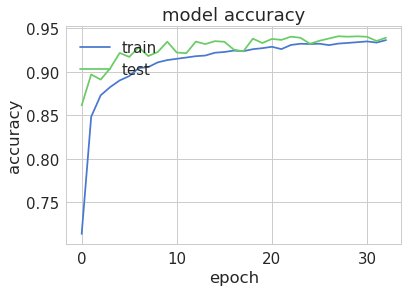

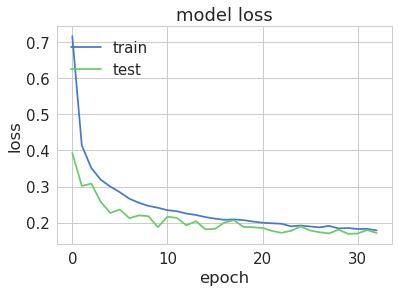

             precision    recall  f1-score   support

     Satire      0.975     0.918     0.946      1371
       Hoax      0.951     0.963     0.957      3587
 Propaganda      0.943     0.942     0.942      2793
    Trusted      0.890     0.907     0.898      2020

avg / total      0.939     0.939     0.939      9771



ValueError: multiclass format is not supported

In [10]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor="val_acc", mode="max", patience=5)

# Build model
if model_type == "CNN-static":
    input_shape = (sequence_length, embedding_dim)
else:
    input_shape = (sequence_length,)

model_input = Input(shape=input_shape)

# Static model does not have embedding layer
if model_type == "CNN-static":
    z = model_input
else:
    z = Embedding(len(vocabulary_inv), 
                  embedding_dim, input_length=sequence_length, 
                  name="embedding")(model_input)

z = Dropout(dropout_prob[0])(z)

# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(len(labels), activation="sigmoid")(z)

model = Model(model_input, model_output)
# model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])
model.summary()

# Initialize weights with word2vec
if model_type == "CNN-non-static":
    weights = np.array([v for v in embedding_weights.values()])
    print("Initializing embedding layer with word2vec weights, shape", weights.shape)
    embedding_layer = model.get_layer("embedding")
    embedding_layer.set_weights([weights])

# Train the model
network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=num_epochs, 
                         callbacks = [early],
                         validation_data=(x_test, y_test), verbose=2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')